In [14]:
## imports and global variables
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
from random import randint
warnings.filterwarnings('ignore')
SEED=randint(0,100)

In [15]:
## read csv, build trainset
train=pd.read_csv('kannada_MNIST.csv')
# train=pd.read_csv('MNIST.csv')
y=train.loc[:,'label'].values
x=train.loc[:,'pixel0':].values
print(x.shape)
print(y)

(10240, 784)
[0 1 2 ... 7 8 9]


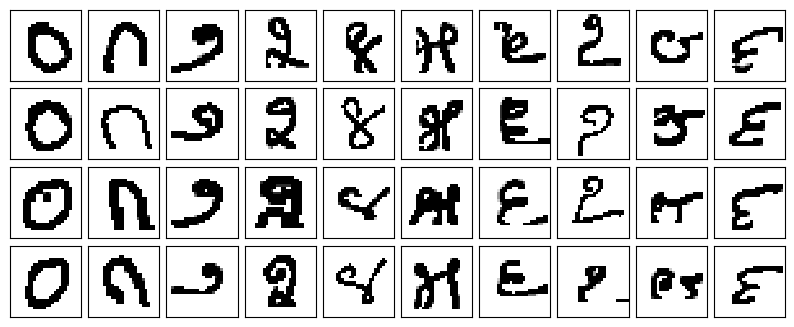

In [16]:
## Plotting the original train data
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28, 28),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(x)

In [17]:
## Standardizing the data
standardized_data = StandardScaler().fit_transform(x)
print(standardized_data.shape)

(10240, 784)


In [18]:
## create subset 
SUBSET_LEN=5000
x_subset = x[0:SUBSET_LEN]
y_subset = y[0:SUBSET_LEN]
print(np.unique(y_subset))


[0 1 2 3 4 5 6 7 8 9]


#### t-SNE
- t-SNE.
- t-SNE after PCA

In [19]:
## t-SNE
tsne=TSNE(random_state = SEED,
          n_components=2,
          verbose=0,
          perplexity=40,
          max_iter=500
          ).fit_transform(x_subset)

In [20]:
## t-SNE after PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(x_subset)
pca_tsne=TSNE(random_state = SEED,
              n_components=2,
              verbose=0,
              perplexity=40,
              max_iter=500
              ).fit_transform(pca_result)

In [22]:
## comparision between tSNE and PCA-tSNE
import altair as alt
import pandas as pd
alt.data_transformers.enable("vegafusion")
WIDTH=500
HEIGHT=500
SAMPLE_FRAC=0.8

tsne_df=pd.DataFrame(tsne,columns=['x1','x2'])
tsne_df['label']=pd.DataFrame(y_subset)
tsne_chart=alt.Chart(tsne_df).mark_point(opacity=0.3).encode(
    x='x1:Q',
    y='x2:Q',
    color='label:N'
).properties(width=WIDTH,height=HEIGHT,title='t-SNE')

pca_tsne_df=pd.DataFrame(tsne,columns=['x1','x2'])
pca_tsne_df['label']=pd.DataFrame(y_subset)
pca_tsne_chart=alt.Chart(pca_tsne_df).mark_point(opacity=0.3).encode(
    x='x1:Q',
    y='x2:Q',
    color='label:N'
).properties(width=WIDTH,height=HEIGHT,title='PCA&t-SNE')
tsne_chart.save('altair/tSNE.png')
pca_tsne_chart.save('altair/PCA_tSNE.png')
(tsne_chart|pca_tsne_chart).save('altair/tSNE and PCA_tSNE.png')
tsne_chart|pca_tsne_chart

alt.HConcatChart(...)

#### Visalisation with matplotlib

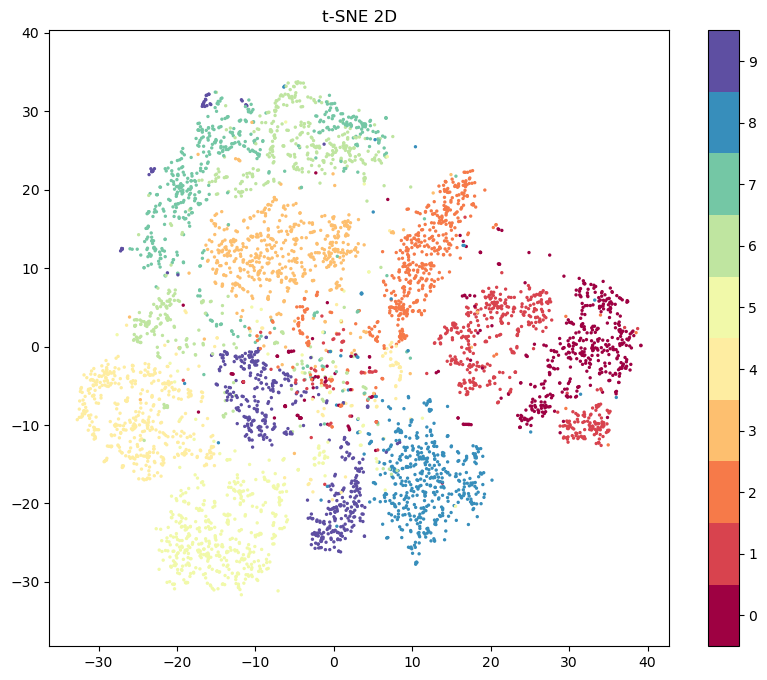

In [28]:
## visalisation: tSNE (plt)
plt.figure(figsize=(10,8))
plt.scatter(tsne[:, 0], tsne[:, 1], s=2, c=y_subset, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('t-SNE 2D')
plt.savefig('plt/tSNE.png')
pass

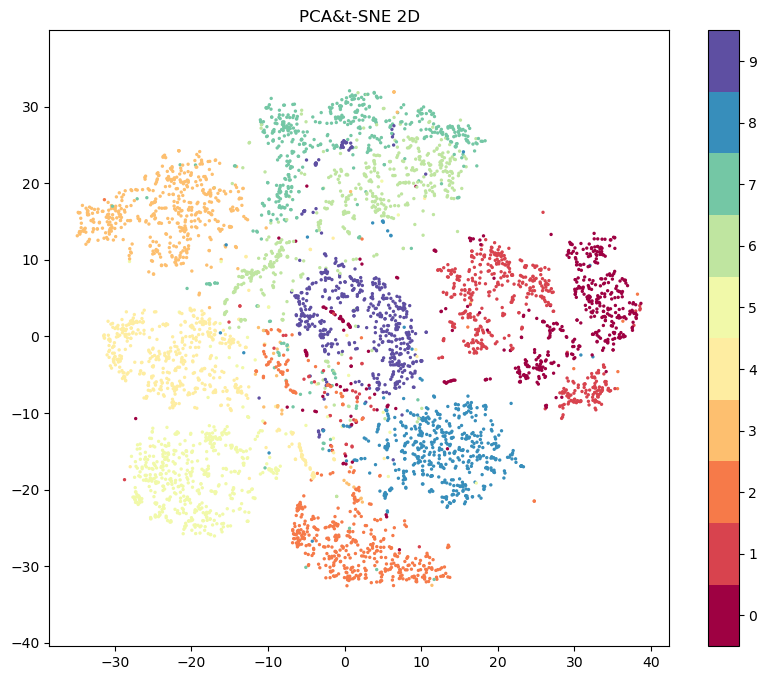

In [29]:
## visualisation: tSNE after PCA (plt)
plt.figure(figsize=(10,8))
plt.scatter(pca_tsne[:, 0], pca_tsne[:, 1], s=2, c=y_subset, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('PCA&t-SNE 2D')
plt.savefig('plt/PCA_tSNE.png')
pass

##### Visaulisation with bokeh

In [30]:
## Encoding all the images for inclusion in a dataframe.
from io import BytesIO
from PIL import Image
import base64
def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((28,28), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [31]:
## loading up bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10
output_notebook()

Loading BokehJS ...

In [32]:
## visalisation: t-SNE (bokeh)
x_subset_reshape = x_subset.reshape(-1,28,28)

digits_df = pd.DataFrame(pca_tsne, columns=('x', 'y'))
digits_df['digit'] = [str(x) for x in y_subset]
digits_df['image'] = list(map(embeddable_image, x_subset_reshape))
datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=list({str(_) for _ in y_subset}),
                                       palette=Spectral10)

plot_figure = figure(
    title='t-SNE 2D',
    width=800,
    height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.scatter(
    'x',
    'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)